In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import pandas as pd
from tqdm import tqdm_notebook as tqdm

uplifted = pd.read_csv('data/peaks.min_peak_score_0.6.thresh_0.5.csv', index_col=0)
# uplifted.drop('Unnamed: 0', inplace=True, axis=1)
uplifted.tail()

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,chrom,start,end,peak_pos,score
1037952,chr22,51240000,51240029,51240015,0.88
1037953,chr22,51240123,51240147,51240135,0.81
1037954,chr22,51240936,51240962,51240949,0.81
1037955,chr22,51242531,51242561,51242546,0.76
1037956,chr22,51243098,51243127,51243116,0.83


In [4]:
df = pd.read_csv('data/chr1.S15-30.filtered.csv', index_col=0)
df.tail()

/home/magas/.pyenv/versions/3.6.0/envs/general/lib/python3.6/site-packages/numpy/lib/arraysetops.py:472: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,start,end,len_stem,len_loop
10941414,249239500.0,249239542.0,18.0,10.0
10941416,249239505.0,249239540.0,15.0,8.0
10941418,249239530.0,249239566.0,15.0,9.0
10941422,249239532.0,249239564.0,16.0,4.0
10941426,249239644.0,249239681.0,17.0,7.0


In [7]:
base_path = "/home/shared/STEMLOOPS/hg19/S16-50_L0-10_M3"
filename = "chr1.fa.S16-50_L0-10_M3.pal.cleaned"
path_to_file = os.path.join(base_path, filename)
with open(path_to_file , 'r') as f:
#     next(f)  # if there is description line
    splitted = f.read().split('\n')  # raw file separated by \n's

cols = ['start', 'end', 'len_stem', 'len_loop']#, 'seq_left', 'seq_right', 'full_seq', '1', '2', '3']
df = pd.DataFrame([sub.split("\t")[:4] for sub in tqdm(splitted)], columns=cols)  # TODO: full file (30 times bigger)
df = df.apply(pd.to_numeric)
df.drop(df.tail(1).index, inplace=True)
df['center'] = df[['start', 'end']].mean(axis=1).astype('int')

df = df.drop_duplicates(subset=['start']).drop_duplicates(['end'])
df.head()


HBox(children=(IntProgress(value=0, max=100048), HTML(value='')))

,start,end,len_stem,len_loop,center
0,10631.0,10680.0,21.0,10.0,10655
1,10660.0,10709.0,21.0,10.0,10684
2,10689.0,10738.0,21.0,10.0,10713
3,10718.0,10767.0,21.0,10.0,10742
4,10747.0,10796.0,21.0,10.0,10771


Провести анализ, в какую область генома попали такие структуры - промотер, ген. Составить таблицу, в которой содержатся названия генов.


In [145]:
ptt = pd.read_csv('data/ptt_hg19.txt', delimiter='\t')
ptt1 = ptt[ptt['chrom'] == 'chr1']
ptt1.tail()


def make_10bp(df, uplifted):
    arr_4_rows = []
    for start_upl in tqdm(pd.to_numeric(uplifted.end)):
        temp_df = df[(df['txStart'] - 1000 < start_upl) & (df['txEnd'] > start_upl) & (df.strand == '+')]
        if not temp_df.empty:
            for ind, row in temp_df.iterrows():
                arr_4_rows.append(row)
    return pd.DataFrame(arr_4_rows)
relevant_ptt = make_10bp(ptt1, ss10bp)
relevant_ptt.tail()

goa = pd.read_csv('data/goa_human.gaf', delimiter='\t', header=None)
goa.tail()

relevant_goa = goa[goa[1].isin(relevant_ptt.proteinID)].drop_duplicates(1)
relevant_goa[9].to_csv('data/relevant_goa_names.csv')

relevant_goa[4].to_csv('data/go_terms.csv', index=False)

,#name,chrom,strand,txStart,txEnd,cdsStart,cdsEnd,exonCount,exonStarts,exonEnds,proteinID,alignID
7962,uc021pmg.1,chr1,+,249168446,249168518,249168446,249168446,1,"249168446,","249168518,",NaN,uc021pmg.1
7963,uc021pmh.1,chr1,+,249211536,249212562,249211536,249212562,1,"249211536,","249212562,",NP_001017434,uc021pmh.1
7964,uc001ifh.3,chr1,+,249200441,249213345,249208061,249212562,3,"249200441,249208014,249210800,","249200541,249208078,249213345,",Q6P3X8,uc001ifh.3
7965,uc001ifg.3,chr1,+,249200441,249213345,249211536,249212562,3,"249200441,249208014,249211477,","249200541,249208078,249213345,",NP_001017434,uc001ifg.3
7966,uc009xhd.3,chr1,+,249200441,249213345,249208750,249212562,4,"249200441,249208014,249208637,249210800,","249200541,249208078,249208758,249213345,",F5H4U7,uc009xhd.3


In [189]:
ss10bp = pd.read_csv('data/sec_struct_0-10bp_to_nucleosome.csv', dtype='int')
ss10bp.tail()

,start,end,len_stem,len_loop,center
3453,46540271,46540305,18,1,46540288
3454,48949696,48949745,20,10,48949720
3455,48949697,48949742,19,8,48949719
3456,50160569,50160602,18,1,50160585
3457,50251558,50251593,16,4,50251575


In [190]:
from Bio import SeqIO
first_record = str(next(SeqIO.parse("/home/shared/hg19/chr1.fna", "fasta")).seq)

temp = pd.DataFrame(np.ndarray((ss10bp.shape[0], 4)), columns=["struct", "before", "after", 'half_struct'], dtype='str')
for idx, row in ss10bp.iterrows():
    temp.loc[idx][0] = first_record[row['start']:row['end']]
    temp.loc[idx][1] = first_record[row['start'] - 20:row['start']]
    temp.loc[idx][2] = first_record[row['end']:row['end'] + 20] 
    temp.loc[idx][3] = first_record[row['start']:row['start'] + (row['end'] - row['start'])//2]

ss10bp = pd.concat([ss10bp, temp], axis=1)
ss10bp.head(2)

,start,end,len_stem,len_loop,center,struct,before,after,half_struct
0,1354102,1354142,17,8,1354122,CAGGCAGGCGCAGGCCTGGTTTCGGGCCTAGCGCCAGGCT,TTCAACTACTGGGTTTAGGC,GCCTGCCTGTCTTTGGTTTT,CAGGCAGGCGCAGGCCTGGT
1,3773878,3773916,16,7,3773897,GGGGCCACGGCACCTGGGCACACCAGGTGGCGTCGCGC,CTCAGGGTTGTGTAGTTTCC,CTTTGCTTTCCTGAGCCTTC,GGGGCCACGGCACCTGGGC


HBox(children=(IntProgress(value=0, max=3458), HTML(value='')))

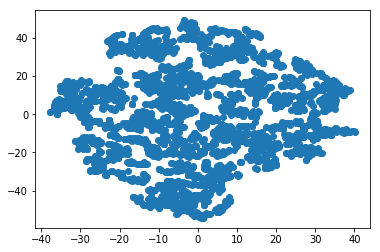

In [191]:
diprodb = pd.read_csv('data/dprops.csv', index_col=0)

import re
features = []
for struct in tqdm(ss10bp['half_struct']):
    strl = re.findall('..', struct)
    temp = []
    for dyad in strl:
        temp.append(diprodb[diprodb['PropertyName'] == dyad].values.tolist()[0])
    features.append(pd.DataFrame(temp,columns=diprodb.columns ).sum())
features = pd.DataFrame(features)


from MulticoreTSNE import MulticoreTSNE as TSNE

tsne = TSNE(n_jobs=8)
Y = tsne.fit_transform(features.loc[:, features.columns != 'PropertyName'])

vis_x = Y[:, 0]
vis_y = Y[:, 1]

plt.scatter(vis_x, vis_y, cmap=plt.cm.get_cmap("jet", 10))
# plt.colorbar(ticks=range(10))
plt.clim(-0.5, 9.5)
plt.show()

In [192]:
X = features.loc[:, features.columns != 'PropertyName'].values

Estimated number of clusters: 121
Silhouette Coefficient: 0.293


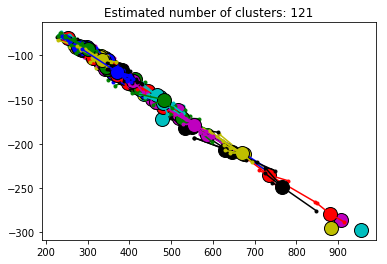

In [193]:
from sklearn.cluster import AffinityPropagation
from sklearn import metrics
af = AffinityPropagation(damping=0.9).fit(X)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

n_clusters_ = len(cluster_centers_indices)

print('Estimated number of clusters: %d' % n_clusters_)

# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels, metric='sqeuclidean'))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt
from itertools import cycle

plt.close('all')
plt.figure(1)
plt.clf()

colors = cycle('bgrcmykbgrcmykbgrcmykbgrcmyk')
for k, col in zip(range(n_clusters_), colors):
    class_members = labels == k
    cluster_center = X[cluster_centers_indices[k]]
    plt.plot(X[class_members, 0], X[class_members, 1], col + '.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
             markeredgecolor='k', markersize=14)
    for x in X[class_members]:
        plt.plot([cluster_center[0], x[0]], [cluster_center[1], x[1]], col)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

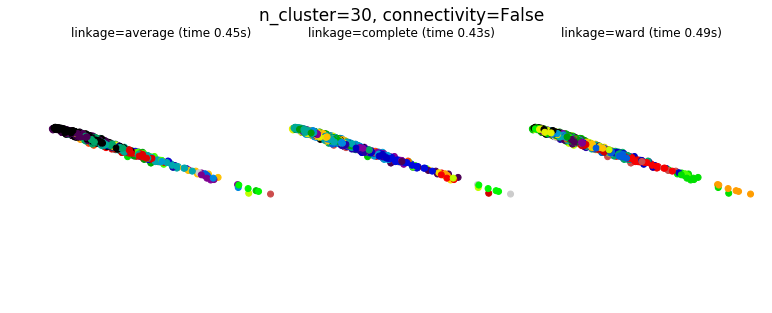

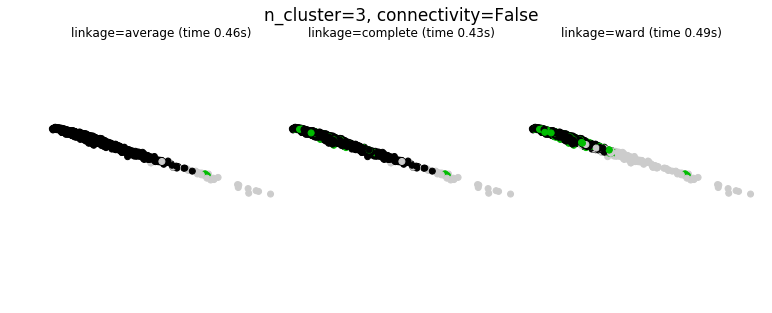

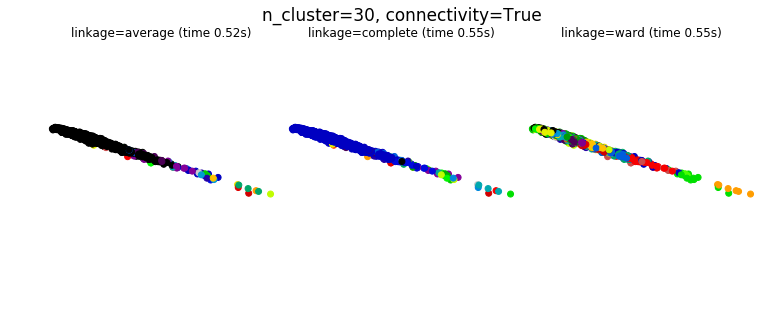

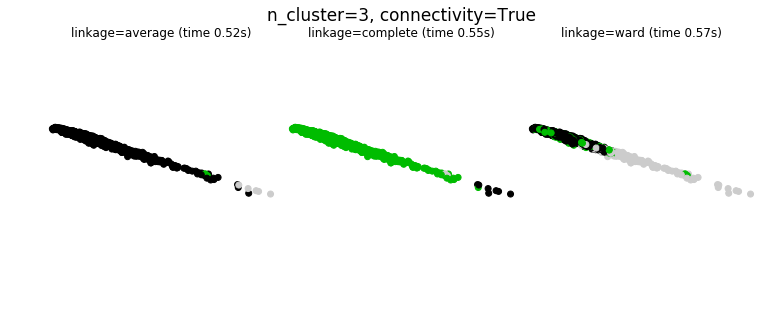

In [194]:

import time
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

# # Generate sample data
# n_samples = 1500
# np.random.seed(0)
# t = 1.5 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
# x = t * np.cos(t)
# y = t * np.sin(t)


# X = np.concatenate((x, y))
# X += .7 * np.random.randn(2, n_samples)
# X = X.T

# Create a graph capturing local connectivity. Larger number of neighbors
# will give more homogeneous clusters to the cost of computation
# time. A very large number of neighbors gives more evenly distributed
# cluster sizes, but may not impose the local manifold structure of
# the data
knn_graph = kneighbors_graph(X, 30, include_self=False)

for connectivity in (None, knn_graph):
    for n_clusters in (30, 3):
        plt.figure(figsize=(10, 4))
        for index, linkage in enumerate(('average', 'complete', 'ward')):
            plt.subplot(1, 3, index + 1)
            model = AgglomerativeClustering(linkage=linkage,
                                            connectivity=connectivity,
                                            n_clusters=n_clusters)
            t0 = time.time()
            model.fit(X)
            elapsed_time = time.time() - t0
            plt.scatter(X[:, 0], X[:, 1], c=model.labels_,
                        cmap=plt.cm.spectral)
            plt.title('linkage=%s (time %.2fs)' % (linkage, elapsed_time),
                      fontdict=dict(verticalalignment='top'))
            plt.axis('equal')
            plt.axis('off')

            plt.subplots_adjust(bottom=0, top=.89, wspace=0,
                                left=0, right=1)
            plt.suptitle('n_cluster=%i, connectivity=%r' %
                         (n_clusters, connectivity is not None), size=17)


plt.show()

In [195]:
import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler


# #############################################################################
# # Generate sample data
# centers = [[1, 1], [-1, -1], [1, -1]]
# X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4,
#                             random_state=0)

# X = StandardScaler().fit_transform(X)

# #############################################################################
# Compute DBSCAN
db = DBSCAN(eps=80).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 56


Silhouette Coefficient: -0.418


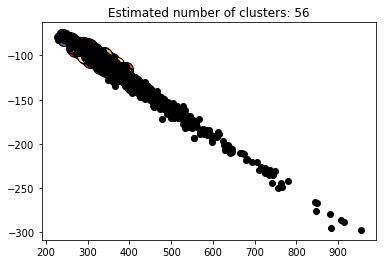

In [196]:
# print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
# print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
# print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
# print("Adjusted Rand Index: %0.3f"
#       % metrics.adjusted_rand_score(labels_true, labels))
# print("Adjusted Mutual Information: %0.3f"
#       % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()